In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = "/home/wuxinchao/data/st_cite_data/B02415A5/"

In [21]:
prot = sc.read_h5ad(f"{data_path}B02415A5_processed_square_bin_human_thymus_prot.h5ad")
rna = sc.read_h5ad(f"{data_path}B02415A5_processed_square_bin_human_thymus_rna.h5ad")

In [22]:
rna_subset = rna[:, rna.var["highly_variable"]]
rna_subset = rna_subset[:, 
        rna_subset.var.sort_values(by="highly_variable_rank").index]

In [23]:
# highly_variable_names = rna_subset.var_names.to_list()
# df = pd.DataFrame(highly_variable_names)
# df.to_csv(f"{save_path}/spCITE_hvg.csv", index=False)

In [24]:
rna_subset.obs['x'] = [i[0] for i in rna_subset.obs_names.str.split("-")]
rna_subset.obs['y'] = [i[1] for i in rna_subset.obs_names.str.split("-")]
rna_subset.obs[["x", "y"]] = rna_subset.obs[["x", "y"]].astype(int)

/tmp/ipykernel_1225153/3607777093.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_subset.obs['x'] = [i[0] for i in rna_subset.obs_names.str.split("-")]


In [25]:
rna.obs[["x", "y"]] = rna_subset.obs[["x", "y"]]

In [26]:
rna

AnnData object with n_obs × n_vars = 4859 × 27886
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'x', 'y'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: '__type', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

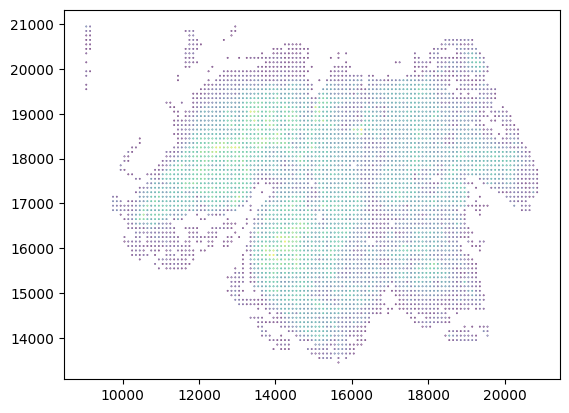

In [27]:
plt.scatter(rna.obsm["spatial"][:,0], rna.obsm["spatial"][:,1], s=0.1, c=rna.obs["total_counts"])

In [32]:
prot

AnnData object with n_obs × n_vars = 4859 × 20
    obs: 'area', 'n_genes_by_counts', 'total_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'log1p', 'pp', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'counts'

In [64]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = rna_subset.X.shape[1]
prot_input_dim = prot.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_subset.obs[["x", "y"]].values, alpha=0.5)

edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_subset.X.A, prot.X.A), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
scData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(scData)

In [70]:
import importlib
import sys

importlib.reload(sys.modules['train'])
# rna_subset.X.A, prot.X.A

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [71]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 83.58641 val_loss: 70.33595
Epoch 2/20 train_loss: 55.82976 val_loss: 35.59711
Epoch 3/20 train_loss: 23.95610 val_loss: 11.74541
Epoch 4/20 train_loss: 7.12777 val_loss: 2.93732
Epoch 5/20 train_loss: 2.67700 val_loss: 2.43894
Epoch 6/20 train_loss: 2.21008 val_loss: 1.74559
Epoch 7/20 train_loss: 1.69362 val_loss: 1.42022
Epoch 8/20 train_loss: 1.45593 val_loss: 1.35453
Epoch 9/20 train_loss: 1.41484 val_loss: 1.30871
Epoch 10/20 train_loss: 1.34318 val_loss: 1.27946
Epoch 11/20 train_loss: 1.29359 val_loss: 1.25798
Epoch 12/20 train_loss: 1.26177 val_loss: 1.23797
Epoch 13/20 train_loss: 1.23920 val_loss: 1.22987
Epoch 14/20 train_loss: 1.23438 val_loss: 1.22176
Epoch 15/20 train_loss: 1.21587 val_loss: 1.21894
Epoch 16/20 train_loss: 1.20489 val_loss: 1.21862
Epoch 17/20 train_loss: 1.19634 val_loss: 1.21298
Epoch 18/20 train_loss: 1.19777 val_loss: 1.20192
Epoch 19/20 train_loss: 1.19030 val_loss: 1.19292
Epoch 20/20 train_loss: 1.18926 val_loss: 1.20437
Epo

In [72]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/human_thymus_stereoCITE_hvg.pt")

In [73]:
model = trainer.best_model

In [74]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(scData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [75]:
np.save("../data/GraphCrossRNArecon_human_thymus_stereoCITE_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_stereoCITE_hvg.npy", prot_recon)

In [76]:
np.save("../data/GraphCrossEmbedding_human_thymus_stereoCITE_hvg.npy", embedding)

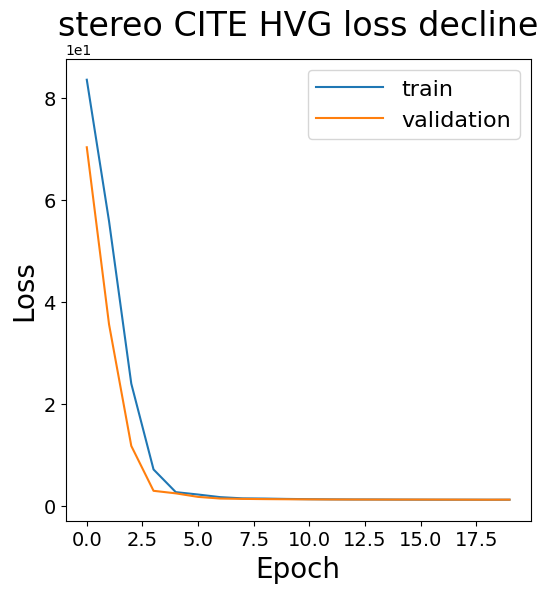

In [77]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("stereo CITE HVG loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("../data/stereo_human_thymus_loss_decline.png")

In [78]:
mdata = mu.MuData({
    "rna": rna,
    "protein": prot,
})
mdata

MuData object with n_obs × n_vars = 4859 × 27906
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
  2 modalities
    rna:	4859 x 27886
      obs:	'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'x', 'y'
      var:	'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
      uns:	'__type', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
      obsm:	'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
      varm:	'PCs'
      layers:	'counts', 'spliced', 'unspliced'
      obsp:	'connectivities', 'distances'
    protein:	4859 x 20
      obs:	'area', 'n_genes_by_counts', 'total_counts'
      var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
      uns:	'__type', 'log1p', 'pp', 'spatial'
      obsm:	'bbox', 'contour', 'spatial'
      layers:	'counts'

## cellbin

In [79]:
data_path

'/home/wuxinchao/data/st_cite_data/B02415A5/'

In [80]:
rna_cellbin = sc.read_h5ad(data_path + "B02415A5_cut_rna.h5ad")
prot_cellbin = sc.read_h5ad(data_path + "B02415A5_cut_protein.h5ad")

In [82]:
rna_cellbin

AnnData object with n_obs × n_vars = 24459 × 27886
    obs: 'area'
    uns: '__type', 'pp', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [83]:
rna_cellbin.var['mt'] = rna_cellbin.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna_cellbin, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

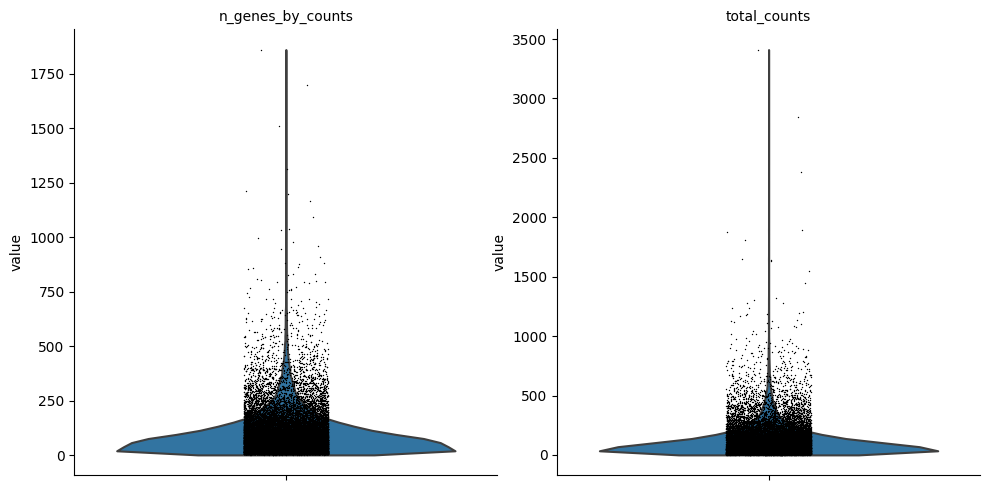

In [84]:
sc.pl.violin(rna_cellbin, ['n_genes_by_counts', 'total_counts'],
             jitter=0.1, multi_panel=True)

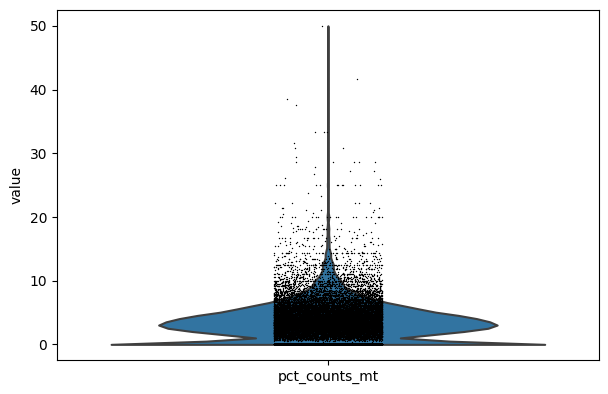

In [85]:
sc.pl.violin(rna_cellbin, ['pct_counts_mt'],
             jitter=0.1)

In [86]:
rna_cellbin = rna_cellbin[rna_cellbin.obs.n_genes_by_counts > 50, :]
rna_cellbin = rna_cellbin[rna_cellbin.obs.total_counts > 100]
rna_cellbin = rna_cellbin[rna_cellbin.obs.pct_counts_mt < 15, :]
rna_cellbin

View of AnnData object with n_obs × n_vars = 10015 × 27886
    obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: '__type', 'pp', 'spatial'
    obsm: 'bbox', 'contour', 'spatial'
    layers: 'spliced', 'unspliced'

In [87]:
sc.pp.filter_cells(rna_cellbin, min_genes=50)

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number
/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/contextlib.py:126: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [89]:
sc.pp.calculate_qc_metrics(prot_cellbin, percent_top=None, log1p=False, inplace=True)

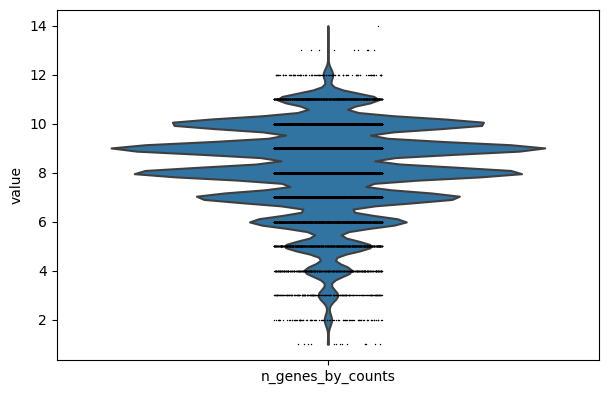

In [90]:
sc.pl.violin(prot_cellbin, ['n_genes_by_counts'],
             jitter=0.1)

In [91]:
prot_cellbin = prot_cellbin[prot_cellbin.obs.n_genes_by_counts > 3, prot_cellbin.X.sum(axis=0)>100]

In [92]:
common_name = set(prot_cellbin.obs_names.to_list()).intersection(
                       set(rna_cellbin.obs_names.to_list() ))
prot_cellbin = prot_cellbin[prot_cellbin.obs_names.isin(common_name), :]
common_name = set(rna_cellbin.obs_names.to_list()).intersection(
                   set(prot_cellbin.obs_names.to_list() ))
rna_cellbin = rna_cellbin[rna_cellbin.obs_names.isin(common_name), :]

In [93]:
rna, prot

(AnnData object with n_obs × n_vars = 4859 × 27886
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'leiden', 'x', 'y'
     var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
     uns: '__type', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'pp', 'spatial', 'umap'
     obsm: 'X_pca', 'X_umap', 'bbox', 'contour', 'spatial'
     varm: 'PCs'
     layers: 'counts', 'spliced', 'unspliced'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 4859 × 20
     obs: 'area', 'n_genes_by_counts', 'total_counts'
     var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
     uns: '__type', 'log1p', 'pp', 'spatial'
     obsm: 'bbox', 'contour', 'spatial'
     layers: 'counts')

In [95]:
rna_cellbin.layers["counts"] = rna_cellbin.X.copy()

In [96]:
sc.pp.normalize_total(rna_cellbin, target_sum=1e4)
sc.pp.log1p(rna_cellbin)
# mouse_thymus_rna.obs_names_make_unique()

In [97]:
sc.pp.highly_variable_genes(
    rna_cellbin,
    n_top_genes=4000,
    flavor="seurat_v3",
    # batch_key="batch_indices",
    layer="counts",
)

In [98]:
sc.tl.pca(rna_cellbin, svd_solver='arpack')
sc.pp.neighbors(rna_cellbin, n_neighbors=10, n_pcs=20)
sc.tl.leiden(rna_cellbin, resolution=.75)
sc.tl.umap(rna_cellbin, spread=1., min_dist=.5, random_state=42)

In [99]:
prot_cellbin.layers["counts"] = prot_cellbin.X.copy()
# protein_adata_pool.X = protein_adata_pool.layers["counts"].copy()
sc.pp.normalize_total(prot_cellbin, target_sum=1e4)
sc.pp.log1p(prot_cellbin)

/tmp/ipykernel_1225153/3733908462.py:1: FutureWarning: X.dtype being converted to np.float32 from uint16. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  prot_cellbin.layers["counts"] = prot_cellbin.X.copy()


In [100]:
rna_cellbin_subset = rna_cellbin[:, rna_cellbin.var["highly_variable"]]
rna_cellbin_subset = rna_cellbin_subset[:, 
        rna_cellbin_subset.var.sort_values(by="highly_variable_rank").index]

In [104]:
rna_cellbin.obsm["spatial"]

array([[6.54333333e+00, 8.39441000e+03],
       [5.88452012e+01, 8.35012074e+03],
       [7.25657568e+01, 8.37726799e+03],
       ...,
       [1.17985845e+04, 4.77402100e+03],
       [1.18373164e+04, 4.80164493e+03],
       [1.23363238e+04, 5.05513294e+03]])

In [105]:
# rna_cellbin_subset.obs['x'] = [i[0] for i in rna_cellbin_subset.obs_names.str.split("-")]
# rna_cellbin_subset.obs['y'] = [i[1] for i in rna_cellbin_subset.obs_names.str.split("-")]
# rna_cellbin_subset.obs[["x", "y"]] = rna_cellbin_subset.obs[["x", "y"]].astype(int)

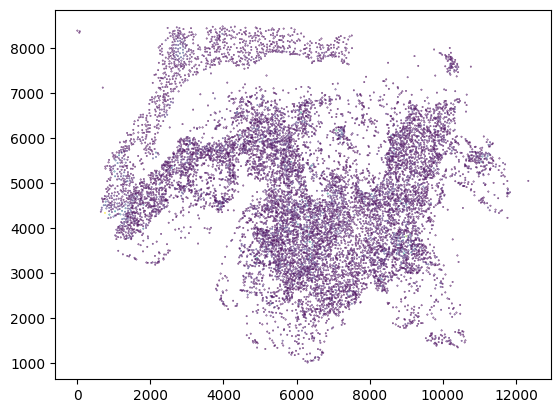

In [106]:
plt.scatter(rna_cellbin.obsm["spatial"][:,0], rna_cellbin.obsm["spatial"][:,1], s=0.1, c=rna_cellbin.obs["total_counts"])

In [107]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = rna_cellbin_subset.X.shape[1]
prot_input_dim = prot_cellbin.X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_cellbin_subset.obsm["spatial"], alpha=0.5)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_cellbin_subset.X.A, prot_cellbin.X.A), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
stData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(stData)

In [70]:
import importlib
import sys

importlib.reload(sys.modules['train'])
# rna_subset.X.A, prot.X.A

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [108]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 255.18184 val_loss: 169.29821
Epoch 2/20 train_loss: 76.53194 val_loss: 19.58399
Epoch 3/20 train_loss: 16.56429 val_loss: 16.25359
Epoch 4/20 train_loss: 14.09738 val_loss: 12.73790
Epoch 5/20 train_loss: 13.02964 val_loss: 12.38575
Epoch 6/20 train_loss: 12.60776 val_loss: 12.20847
Epoch 7/20 train_loss: 12.45916 val_loss: 12.06058
Epoch 8/20 train_loss: 12.23218 val_loss: 11.91130
Epoch 9/20 train_loss: 12.03719 val_loss: 11.72870
Epoch 10/20 train_loss: 11.85174 val_loss: 11.41665
Epoch 11/20 train_loss: 11.29212 val_loss: 10.94486
Epoch 12/20 train_loss: 10.41547 val_loss: 9.93102
Epoch 13/20 train_loss: 9.49616 val_loss: 9.11668
Epoch 14/20 train_loss: 8.48461 val_loss: 8.16436
Epoch 15/20 train_loss: 7.44817 val_loss: 7.09243
Epoch 16/20 train_loss: 6.25423 val_loss: 5.84302
Epoch 17/20 train_loss: 5.03995 val_loss: 4.92674
Epoch 18/20 train_loss: 4.02749 val_loss: 4.52687
Epoch 19/20 train_loss: 3.60068 val_loss: 3.79868
Epoch 20/20 train_loss: 3.31739 va

In [109]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/human_thymus_stereoCITE_cellbin_hvg.pt")

In [110]:
model = trainer.best_model

In [112]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(stData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [113]:
np.save("../data/GraphCrossRNArecon_human_thymus_stereoCITE_cellbin_hvg.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_human_thymus_stereoCITE_cellbin_hvg.npy", prot_recon)

In [114]:
np.save("../data/GraphCrossEmbedding_human_thymus_stereoCITE_cellbin_hvg.npy", embedding)

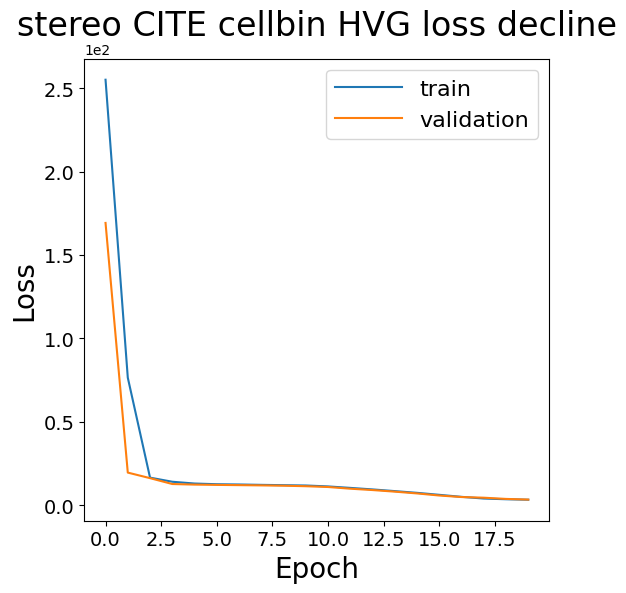

In [115]:
# plot the training and validation loss
plt.figure(figsize=(6,6))
plt.plot(train_losses[0], label="train")
plt.plot(val_losses[0], label="validation")
plt.title("stereo CITE cellbin HVG loss decline", fontsize=24)
plt.ylabel("Loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(prop={'size': 16, 'weight': 'normal'}, handlelength=3)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig("../data/stereo_cellbin_human_thymus_loss_decline.png")

In [117]:
rna_cellbin.write_h5ad(f"{data_path}processed_human_thymus_cellbin_rna.h5ad")
prot_cellbin.write_h5ad(f"{data_path}processed_human_thymus_cellbin_prot.h5ad")

# Spatial CITE-seq mouse spleen

In [1]:
import muon as mu
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import torch
from dataset import GeneVocab
from dataset import SinglecellData
from torch_geometric.data import Data
from torch_geometric.transforms import RandomNodeSplit

/home/wuxinchao/software/miniconda3/envs/pytorch-gpu/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_path = "/home/wuxinchao/data/st_cite_data/spatial_cite_data/"
spCITE_mouse_spleen = f"{save_path}mouse_spleen_spCITE.h5mu"

In [3]:
mdata = mu.read_h5mu(spCITE_mouse_spleen)
mdata

MuData object with n_obs × n_vars = 1222 × 16226
  var:	'n_cells'
  2 modalities
    rna:	1222 x 16033
      obs:	'n_genes', 'x', 'y', 'leiden'
      var:	'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
      uns:	'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap', 'spatial'
      varm:	'PCs'
      layers:	'counts'
      obsp:	'connectivities', 'distances', 'spatial_proximity'
    prot:	1222 x 193
      obs:	'n_genes', 'x', 'y'
      var:	'n_cells'
      uns:	'log1p'
      obsm:	'spatial'
      layers:	'counts'

In [6]:
rna_subset = mdata['rna'][:, mdata['rna'].var["highly_variable"]]

In [11]:
from utils import build_adjacency_matrix_torch

model_choice = "Graph Cross Attention"

rna_input_dim = rna_subset.X.shape[1]
prot_input_dim = mdata['prot'].X.shape[1]

hidden_dim = 32
embedding_dim = 32
heads = 4
num_blocks = 2
permute = False
preserve_rate = 0.2
alpha = 0.4
beta = 0.4

# setting for the trainer
batch_size = 256
lr = 1e-3
epochs = 20
mask_ratio = 0.85
num_splits = 2
device = torch.device(
    'cuda' if torch.cuda.is_available() else 'cpu')

adj_mtx = build_adjacency_matrix_torch(rna_subset.obsm["spatial"], alpha=0.9)
edge_index = adj_mtx.nonzero().T.contiguous().to(device)
concat_data = np.concatenate((rna_subset.X, mdata['prot'].X), axis=1)
concat_data = torch.tensor(concat_data, dtype=torch.float32).to(device)
stData = Data(x=concat_data, edge_index=edge_index)

num_splits = 2
num_val = 0.4
num_test = 0.2

tsf = RandomNodeSplit(
    num_splits=num_splits, 
    num_val=num_val, 
    num_test=num_test, 
    key=None
)

training_data = tsf(stData)

In [12]:
edge_index.shape

torch.Size([2, 110916])

In [70]:
import importlib
import sys

importlib.reload(sys.modules['train'])
# rna_subset.X.A, prot.X.A

<module 'train' from '/DATA/User/wuxinchao/project/spatial-CITE-seq/sc_st_attention_integration/GSPI/train.py'>

In [13]:
from train import Trainer

trainer = Trainer(
    training_data,
    model_choice=model_choice, 
    rna_input_dim=rna_input_dim, 
    prot_input_dim=prot_input_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    heads=heads,
    num_blocks=num_blocks, 
    batch_size=batch_size,
    lr=lr,
    epochs=epochs,
    mask_ratio=0.85,
    permute=False,
    preserve_rate=preserve_rate,
    num_splits=num_splits,
    device=device,
    alpha=alpha,
    beta=beta,
)

train_losses, val_losses = trainer.train()

Epoch 1/20 train_loss: 11.68556 val_loss: 11.45175
Epoch 2/20 train_loss: 11.35174 val_loss: 11.11816
Epoch 3/20 train_loss: 10.98281 val_loss: 10.66243
Epoch 4/20 train_loss: 10.50826 val_loss: 10.12381
Epoch 5/20 train_loss: 9.98501 val_loss: 9.53910
Epoch 6/20 train_loss: 9.35248 val_loss: 8.87939
Epoch 7/20 train_loss: 8.69390 val_loss: 8.25649
Epoch 8/20 train_loss: 8.04057 val_loss: 7.63003
Epoch 9/20 train_loss: 7.39832 val_loss: 6.96082
Epoch 10/20 train_loss: 6.78677 val_loss: 6.33309
Epoch 11/20 train_loss: 6.12923 val_loss: 5.74161
Epoch 12/20 train_loss: 5.53440 val_loss: 5.19641
Epoch 13/20 train_loss: 5.01610 val_loss: 4.70662
Epoch 14/20 train_loss: 4.55762 val_loss: 4.29521
Epoch 15/20 train_loss: 4.13826 val_loss: 3.94764
Epoch 16/20 train_loss: 3.82638 val_loss: 3.67138
Epoch 17/20 train_loss: 3.54978 val_loss: 3.45802
Epoch 18/20 train_loss: 3.35229 val_loss: 3.29654
Epoch 19/20 train_loss: 3.20940 val_loss: 3.16411
Epoch 20/20 train_loss: 3.07343 val_loss: 3.04064
E

In [14]:
# save the best model parameters
save_dict = {
    "model": trainer.best_model.state_dict(),
    "optimizer": trainer.optimizer.state_dict(),
}
torch.save(save_dict, "../save_model/mouse_spleen_spCITE_hvg_sp_integrate.pt")

In [15]:
model = trainer.best_model

In [16]:
model.eval()
with torch.no_grad():
    rna_recon, prot_recon, embedding = model(stData)
    rna_recon = rna_recon.cpu().numpy()
    prot_recon = prot_recon.cpu().numpy()
    embedding = embedding.cpu().numpy()

In [17]:
np.save("../data/GraphCrossRNArecon_mouse_spleen_spCITE_hvg_sp_integrate.npy", rna_recon)
np.save("../data/GraphCrossPorteinrecon_mouse_spleen_spCITE_hvg_sp_integrate.npy", prot_recon)

In [18]:
np.save("../data/GraphCrossEmbedding_mouse_spleen_spCITE_hvg_sp_integrate.npy", embedding)